In [39]:
import pandas as pd
import numpy as np
# custom made functions (can be a pain to import sometimes)
import sys
sys.path.insert(0,os.path.abspath('../src/helper'))
from customPandas import *
#saving the model
import pickle
import random

## Loading the data

In [40]:
# https://stackoverflow.com/questions/39125532/file-does-not-exist-in-jupyter-notebook
dataPath = os.path.abspath('../data')
fileName = 'ramen-ratings.csv'
df = pd.read_csv(f'{dataPath}/{fileName}') 

## Cleaning some of the data

In [41]:
def cleanStars(value):
    if value == 'Unrated':
        return np.nan
    else:
        return value
df.Stars = df.Stars.apply(cleanStars) 
df[df.Stars == 'Unrated'].Stars

Series([], Name: Stars, dtype: object)

In [42]:
df = df.drop(['Review #','Top Ten'],axis=1)

In [43]:
df = df.fillna(method='ffill')

In [44]:
totalPercentageNullData(df)

,Total,Percent


In [45]:
# changing an incorrect dtype
df = df.astype({'Stars':'float64'})

In [46]:
df.describe()

,Stars
count,2580.000000
mean,3.654884
std,1.014886
min,0.000000
25%,3.250000
50%,3.750000
75%,4.250000
max,5.000000


In [47]:
Y = df['Stars']
df = df.drop(['Stars'],axis=1)

In [48]:
df[df['Brand'].isin(['Nongshim']) & df['Variety'].str.contains('Shin Ramyun')]

,Brand,Variety,Style,Country
47,Nongshim,Shin Ramyun Black,Pack,South Korea
76,Nongshim,Shin Ramyun,Pack,South Korea
1017,Nongshim,Shin Ramyun Noodle Soup (New Edition),Pack,USA
1393,Nongshim,Shin Ramyun Cup,Cup,South Korea
1536,Nongshim,Shin Ramyun Noodle Spicy Mushroom,Bowl,China
1582,Nongshim,Shin Ramyun Black Spicy Beef,Cup,South Korea
1829,Nongshim,Shin Ramyun Black Onion,Cup,South Korea
1903,Nongshim,Shin Ramyun Shrimp,Pack,China
2002,Nongshim,Shin Ramyun Black,Pack,South Korea
2561,Nongshim,Shin Ramyun,Pack,South Korea


In [49]:
df.groupby(by=['Brand']).count()

,Variety,Style,Country
Brand,,,
1 To 3 Noodles,1,1,1
7 Select,2,2,2
7 Select/Nissin,1,1,1
A-One,4,4,4
A-Sha Dry Noodle,26,26,26
...,...,...,...
Yum Yum,12,12,12
Yum-Mie,1,1,1
Zow Zow,1,1,1


In [50]:
Y

0       3.75
1       1.00
2       2.25
3       2.75
4       3.75
        ... 
2575    3.50
2576    1.00
2577    2.00
2578    2.00
2579    0.50
Name: Stars, Length: 2580, dtype: float64

## Custom Transformers

In [51]:
from nltk.corpus import stopwords
import string
def nltkPreprocess(text):
    """
    Description:
        - Takes a text and cleans it by removing useless punctuations and stopwords
    input:
        -string
    output:
        - list of strings
    """
    # lower
    words = text.lower().split()
    # remove punctiuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    clean = [w for w in stripped if not w in stop_words if len(w)>2]
    return clean 


def cleanVariety(col):
    """
    description:
        - adaptation for 
    """
    cleanCol = list()
    # print(col)
    for v in col:
        # print(type(v))
        cleanCol.append(nltkPreprocess(v[0]))
    return col

In [52]:
# we are trying to make feature engineering part of our pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
#! because the way .fit works in sklearn it passes the arrays as np.array so you must specify
mapper = ColumnTransformer(transformers=[
('Variety', FunctionTransformer(cleanVariety, validate=False),[1])], remainder='passthrough')


## Pipeline

In [ ]:
catFeats = df.dtypes[df.dtypes == 'object'].index.tolist()

def catFeat(df):
    return df[catFeats]

keepCat = FunctionTransformer(catFeat)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('VarietyColNLPClean',mapper),
    ('ohc',OneHotEncoder(handle_unknown='ignore')),
    ('to_dense',ToDenseTransformer()),
    ('pca',PCA())
    ])

In [ ]:
# very usefull pipeline visualization
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('VarietyColNLPClean',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Variety',
                                                  FunctionTransformer(func=<function cleanVariety at 0x7f915ed61940>),
                                                  [1])])),
                ('ohc', OneHotEncoder(handle_unknown='ignore')),
                ('to_dense',
                 <customPandas.ToDenseTransformer object at 0x7f9160040cd0>),
                ('pca', PCA())])

## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge, Lasso, Ridge
regressors = [BayesianRidge(),Lasso(), Ridge()]
# hyperparameter tuning for the Randomized Search
params = [{'regressors':[BayesianRidge()],
'regressors__n_iter' : [x for x in np.linspace(start=300,stop =1000,num=8)],
'regressors__alpha_1' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)],
# 'pipeline__pca__n_components': [round(x) for x in np.linspace(start=3,stop = 100,num=8)]
},
{'regressors':[Lasso()],
'regressors__alpha' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)],
# preprocessing pipeline
# 'pipeline__pca__n_components': [round(x) for x in np.linspace(start=3,stop = 100,num=8)]
},

{'regressors':[Ridge()],
'regressors__alpha' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)],
# preprocessing pipeline
# 'pipeline__pca__n_components':[round(x) for x in np.linspace(start=3,stop = 100,num=8)]
}]
# if looking for specific parameters use the get_params methods (e.g.Lasso().get_params())

In [ ]:
# preprocessor.get_params()

In [ ]:
from sklearn.model_selection import train_test_split
# split of the datasla
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.33, random_state=42)

In [ ]:
baseModel = Pipeline([('categories', pipeline),
                      ('regressors', regressors[0])])
baseModel

Pipeline(steps=[('categories',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value='missing',
                                                strategy='constant')),
                                 ('VarietyColNLPClean',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Variety',
                                                                   FunctionTransformer(func=<function cleanVariety at 0x7f915ed61940>),
                                                                   [1])])),
                                 ('ohc',
                                  OneHotEncoder(handle_unknown='ignore')),
                                 ('to_dense',
                                  <customPandas.ToDenseTransformer object at 0x7f9160040cd0>),
                                 ('pca', PCA())])),
                ('regressors', BayesianRidge())])

In [ ]:
pipeline['pca'].get_params()

In [ ]:
tunedModel = RandomizedSearchCV(baseModel,params,verbose=1,n_iter=150, cv=5,random_state=42).fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 10.4min finished


In [23]:
print("model score training data: %.3f" % tunedModel.score(X_train, y_train)) 
print("model score test data: %.3f" % tunedModel.score(X_test, y_test))
print(tunedModel.best_estimator_.get_params)
tunedModel.best_params_

model score training data: 0.836
model score test data: 0.235
<bound method Pipeline.get_params of Pipeline(steps=[('categories',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value='missing',
                                                strategy='constant')),
                                 ('VarietyColNLPClean',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Variety',
                                                                   FunctionTransformer(func=<function cleanVariety at 0x7f915ed61940>),
                                                                   [1])])),
                                 ('ohc',
                                  OneHotEncoder(handle_unknown='ignore')),
                                 ('to_dense',
                                  <customPandas.ToDenseTransformer object at 0x7f916015eeb0>),
    

{'regressors__alpha': 1.0, 'regressors': Ridge()}

In [24]:
y_pred = tunedModel.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
mean_absolute_error(y_test,y_pred)

0.6350940579686039

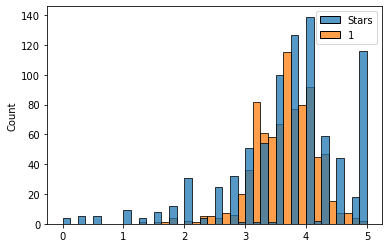

In [25]:
sns.histplot([y_test,y_pred]);

In [51]:
modelPath = os.path.abspath('../src/models/')
filename = 'veryBasicModelMK1.sav'
modelPath

'/Users/zumiis/ramenML/src/models'

In [52]:
# save the model to disk
pickle.dump(tunedModel, open(f'{modelPath}/{filename}', 'wb'))

In [53]:
# load the model from disk
loaded_model = pickle.load(open(f'{modelPath}/{filename}', 'rb'))

In [54]:
y_pred = loaded_model.predict(X_test)

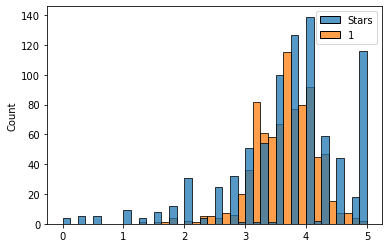

In [55]:
sns.histplot([y_test,y_pred]);

In [56]:
newRandoData ={ 
    'Brand':'Master Kong',
    'Variety':'Onion Soy sauce sour kimchi prawn ramyun',
    'Style':'cup',
    'Country': 'Japan'
}
newSeries = pd.Series(newRandoData)

In [57]:
def randomNoods():
    nood = [random.choice(df[i]) for i in df.columns.to_list()]
    print(nood)
    return nood

In [58]:
loaded_model.predict([newSeries])

array([4.29577195])

In [59]:
loaded_model.predict([randomNoods()])

['JML', 'South Korean Broad Noodle', 'Pack', 'Singapore']


ValueError: SimpleImputer does not support data with dtype <U25. Please provide either a numeric array (with a floating point or integer dtype) or categorical data represented either as an array with integer dtype or an array of string values with an object dtype.

In [ ]:
df.head()

In [ ]:
dropDownVals = {
    'Brand' : df.Brand.unique().tolist(),
    'Style' : df.Style.unique().tolist(),
    'Country' : df.Country.unique().tolist()
    }

In [ ]:
import json

In [ ]:
jsonFilename = 'DjangoRamenMLDropDownVals'
with open(f'{modelPath}/{jsonFilename}.json', 'w') as fp:
    json.dump(dropDownVals, fp)